## Imports

In [ ]:
# === Gestion des données ===
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# === Visualisation ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Modèles
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# === Features supplémentaires ===
from vacances_scolaires_france import SchoolHolidayDates

# === Divers ===
import requests
import warnings
warnings.filterwarnings("ignore")


## Préparation des données 

In [3]:
df = pd.read_csv("Bakery_sales.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


### les types de données 

In [5]:
# date: date order format : yyyy-mm-dd object
# time: time order : hours:minutes object
# ticket number: identifier for every single transaction float64
# article: name of the product sold (in French) The product COUPE is when customers ask to slice (with a machine) their whole bread. object

# Quantity: quantity sold float64
# unit_price: price per product exemple : 0,90 € object

<Axes: ylabel='count'>

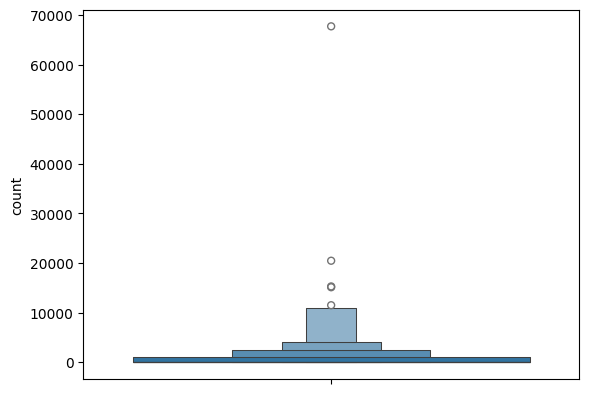

In [5]:
sns.boxenplot(df["article"].value_counts())

## Selections des articles + ajout de la feature vacance 

In [ ]:
# --- Top 50 articles --- (choisit par tatonnement)
article_counts = df.groupby("article")["Quantity"].sum()
top_articles = article_counts.sort_values(ascending=False).head(50).index
df = df[df["article"].isin(top_articles)]

# --- Nettoyage colonnes ---
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S").dt.time


# --- Agrégation des ventes par jour et par article ---
df_daily = (
    df.groupby(["date", "article"], as_index=False)["Quantity"]
    .sum()
)

# --- Pivot : articles en colonnes ---
df_pivot = df_daily.pivot(index="date", columns="article", values="Quantity").fillna(0)

# --- Ajout de features temporelles ---
df_pivot["day_of_week"] = df_pivot.index.dayofweek
df_pivot["month"] = df_pivot.index.month


years = [2022, 2023]
zone = "C"

vacances = SchoolHolidayDates()
vacances_dates = set()

for y in years:
    d = vacances.holidays_for_year_and_zone(y, zone)
    for date, infos in d.items():
        if infos[f"vacances_zone_{zone.lower()}"]:
            vacances_dates.add(pd.to_datetime(date))

df_pivot["is_vacances"] = df_pivot.index.isin(vacances_dates).astype(int)


<Axes: xlabel='date'>

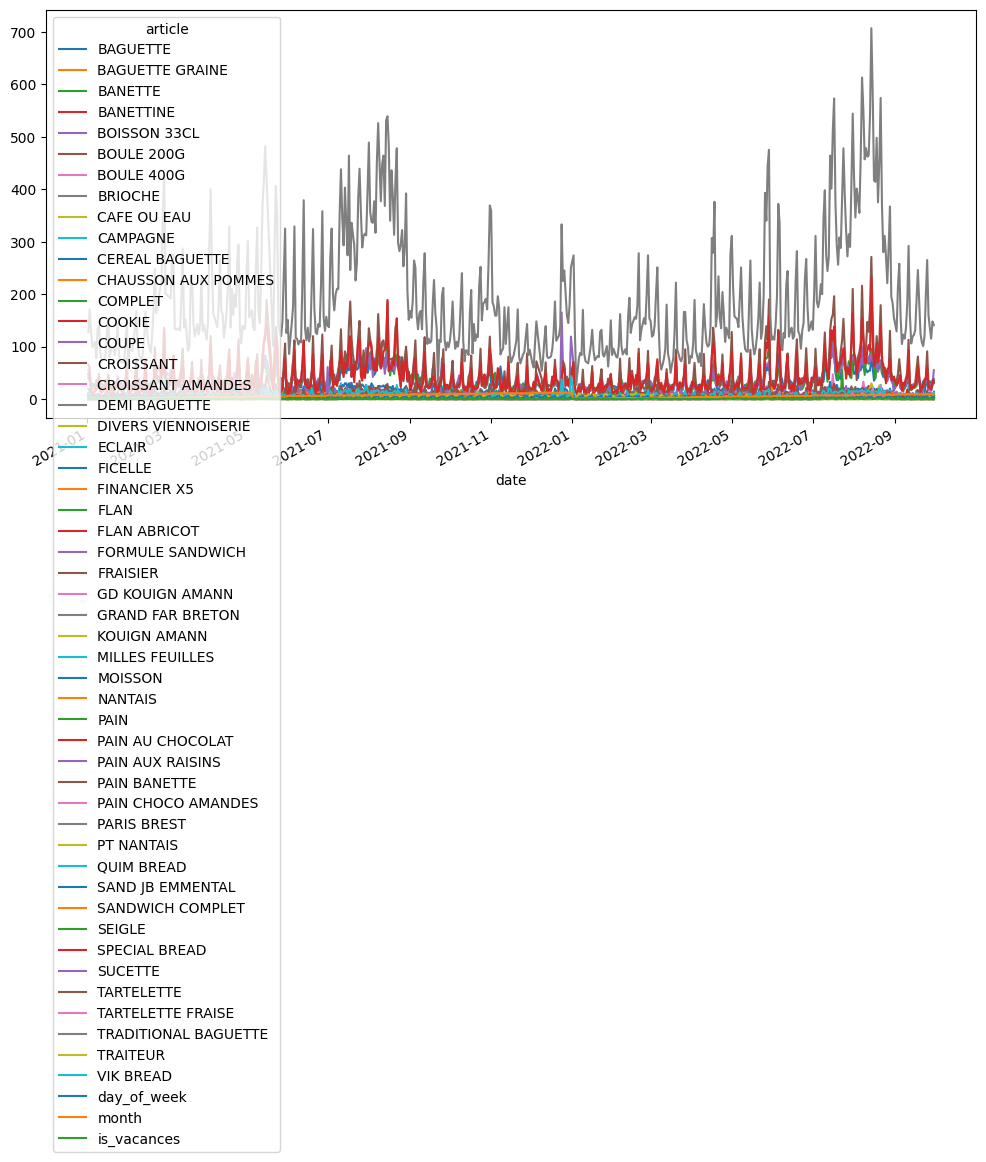

In [18]:
df_pivot.plot(figsize=(12,6))

## récupérer les données météo

In [21]:
# coordonnées Paris (je ne connais pas la loc du commerce)
latitude, longitude = 48.8566, 2.3522

start_date = df_pivot.index.min().strftime("%Y-%m-%d")
end_date   = df_pivot.index.max().strftime("%Y-%m-%d")

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
    f"&timezone=Europe%2FParis"
)

response = requests.get(url).json()
df_weather = pd.DataFrame(response["daily"])

# merge météo + ventes
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_pivot = df_pivot.merge(df_weather, left_index=True, right_on="time").set_index("time")


## Définir X et Y -> on choisit ce qui est le plus vendu à savoir la baguette tradi 

In [12]:
target = "TRADITIONAL BAGUETTE"
X = df_pivot.drop(columns=[target])
y = df_pivot[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


## test des models 

### XGB test model


In [14]:
model = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=6
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))


MAE: 42.864184315999346
MAPE: 0.14911756135171916


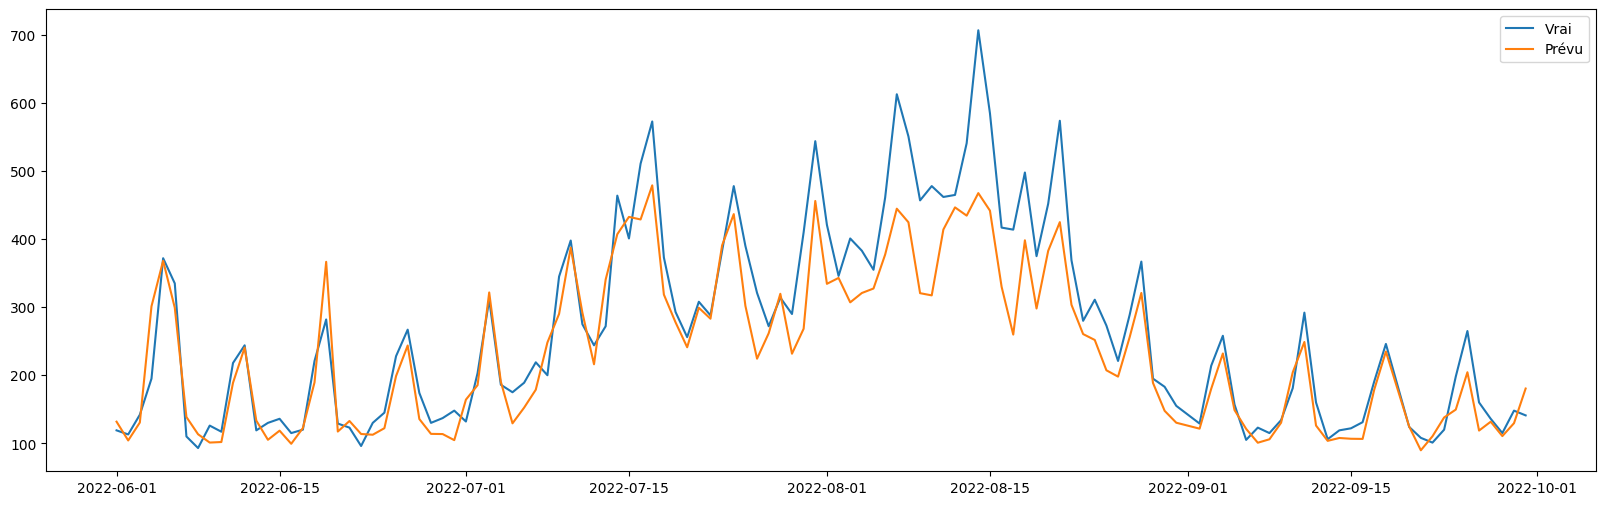

In [15]:
plt.figure(figsize=(20,6))
plt.plot(y_test.index, y_test, label="Vrai")
plt.plot(y_test.index, y_pred, label="Prévu")
plt.legend()
plt.show()


In [ ]:
### on sont les plus grosses erreurs, on voit des grosses erreur dans le mois d'aout à priori un evenement pas prise en compte dans le model

In [17]:
errors = (y_test - y_pred).abs()
outliers = errors[errors > errors.mean() + 2*errors.std()]
print(outliers)


time
2022-07-30    141.683105
2022-08-07    168.217499
2022-08-09    136.384552
2022-08-10    160.625702
2022-08-14    239.326538
2022-08-15    143.092438
2022-08-17    154.261841
2022-08-21    148.963074
Name: TRADITIONAL BAGUETTE, dtype: float64


### Random forest regressor

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_rf))

MAE: 43.99031132188338
MAPE: 0.1471401448451544


### lightgbm 

In [ ]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_lgb))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 55
[LightGBM] [Info] Start training from score 177.985417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

### CatBoost

In [ ]:
cat_model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="MAE",
    verbose=0
)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_cat))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_cat))


MAE: 43.83482874642315
MAPE: 0.1434019029157853


## light gbm grid search (meilleur modèle)

In [26]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Modèle de base
lgb_estimator = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

# Grille réduite
param_dist = {
    "num_leaves": [31, 63, 127],
    "max_depth": [6, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 500],
    "min_child_samples": [10, 20, 50]
}

# RandomizedSearch
search = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit avec early stopping → via fit_params
search.fit(
    X_train, y_train,
    **{
        "eval_set": [(X_test, y_test)],
        "eval_metric": "mae",
        "callbacks": [lgb.early_stopping(50)]
    }
)

print("Meilleurs paramètres :", search.best_params_)
best_lgb = search.best_estimator_

# Évaluation finale
y_pred_best = best_lgb.predict(X_test)
print("MAE Test:", mean_absolute_error(y_test, y_pred_best))
print("MAPE Test:", mean_absolute_percentage_error(y_test, y_pred_best))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, rep

In [26]:
best_params = {'num_leaves': 63, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.1}

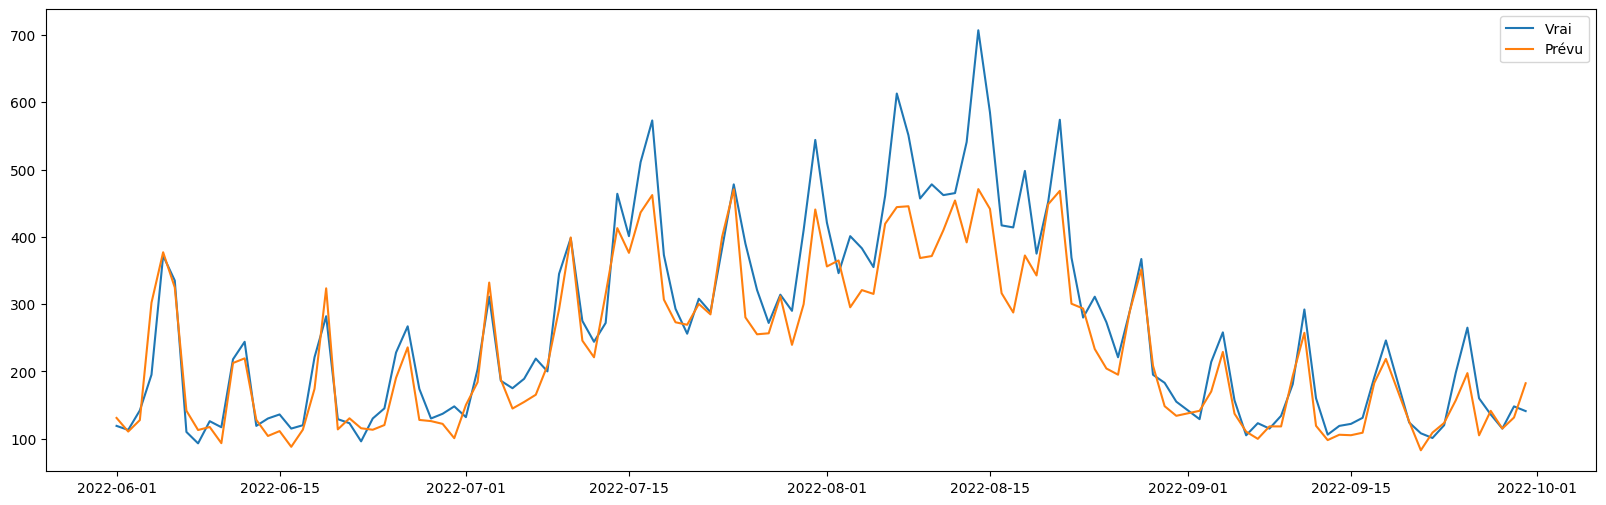

In [27]:
plt.figure(figsize=(20,6))
plt.plot(y_test.index, y_test, label="Vrai")
plt.plot(y_test.index, y_pred_best, label="Prévu")
plt.legend()
plt.show()


In [28]:
errors = (y_test - y_pred_best).abs()
outliers = errors[errors > errors.mean() + 2*errors.std()]
print(outliers)

time
2022-08-07    168.822893
2022-08-13    149.252341
2022-08-14    236.070358
2022-08-15    143.463898
2022-08-17    126.471222
2022-08-18    125.714286
Name: TRADITIONAL BAGUETTE, dtype: float64


In [ ]:
#On voit qu'on a toujours un problème pendant le mois d'aout le reste c'est plutot bon, si on avait plus d'info sur la boulangerie on aurait pu faire quelque chose de mieux

## test avec d'autres produits

In [38]:
def evaluate_top_products(df_pivot, best_params, top_n=30):
    """
    Entraîne un modèle LightGBM pour les top produits,
    calcule MAE + erreur relative,
    compare aux baselines (moyenne, persistance J-1, persistance S-1).

    Args:
        df_pivot (pd.DataFrame): dataframe agrégé par jour avec ventes + features
        best_params (dict): hyperparams LightGBM optimisés
        top_n (int): nombre de produits à tester (ex. top 30)

    Returns:
        dict : résultats par produit
    """

    # Sélection des produits les plus vendus
    top_products = df_pivot.sum().sort_values(ascending=False).head(top_n).index.tolist()

    results = {}

    for target in top_products:
        import warnings
        warnings.filterwarnings("ignore")


        print(f"\n--- {target} ---")

        # Séparer X et y
        X = df_pivot.drop(columns=[target])
        y = df_pivot[target]

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )

        # Modèle LightGBM
        model = lgb.LGBMRegressor(**best_params, random_state=42,verbose=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Baselines
        baseline_mean = np.repeat(y_train.mean(), len(y_test))
        baseline_day1 = y_test.shift(1).fillna(y_train.mean())
        baseline_week = y_test.shift(7).fillna(y_train.mean())

        # Metrics modèle
        mae_model = mean_absolute_error(y_test, y_pred)
        rel_model = mae_model / y_test.mean() if y_test.mean() > 0 else 0

        # Metrics baselines
        mae_mean = mean_absolute_error(y_test, baseline_mean)
        rel_mean = mae_mean / y_test.mean() if y_test.mean() > 0 else 0

        mae_day1 = mean_absolute_error(y_test, baseline_day1)
        rel_day1 = mae_day1 / y_test.mean() if y_test.mean() > 0 else 0

        mae_week = mean_absolute_error(y_test, baseline_week)
        rel_week = mae_week / y_test.mean() if y_test.mean() > 0 else 0

        # Sauvegarde résultats
        results[target] = {
            "model": model,
            "MAE_model": mae_model,
            "RelError_model": rel_model,
            "MAE_baseline_mean": mae_mean,
            "RelError_baseline_mean": rel_mean,
            "MAE_baseline_day1": mae_day1,
            "RelError_baseline_day1": rel_day1,
            "MAE_baseline_week": mae_week,
            "RelError_baseline_week": rel_week,
        }

        # Affichage rapide
        print(f"Model → MAE: {mae_model:.2f}, RelErr: {rel_model:.2%}")
        print(f"Mean  → MAE: {mae_mean:.2f}, RelErr: {rel_mean:.2%}")
        print(f"Day-1 → MAE: {mae_day1:.2f}, RelErr: {rel_day1:.2%}")
        print(f"Week-1→ MAE: {mae_week:.2f}, RelErr: {rel_week:.2%}")

    return results


In [41]:
results = evaluate_top_products(df_pivot, best_params, top_n=20)



--- TRADITIONAL BAGUETTE ---
Model → MAE: 40.66, RelErr: 15.23%
Mean  → MAE: 124.99, RelErr: 46.83%
Day-1 → MAE: 64.36, RelErr: 24.11%
Week-1→ MAE: 67.64, RelErr: 25.34%

--- CROISSANT ---
Model → MAE: 12.36, RelErr: 18.30%
Mean  → MAE: 37.88, RelErr: 56.07%
Day-1 → MAE: 31.86, RelErr: 47.15%
Week-1→ MAE: 27.79, RelErr: 41.13%

--- PAIN AU CHOCOLAT ---
Model → MAE: 10.65, RelErr: 18.79%
Mean  → MAE: 28.08, RelErr: 49.57%
Day-1 → MAE: 23.92, RelErr: 42.23%
Week-1→ MAE: 21.68, RelErr: 38.27%

--- COUPE ---
Model → MAE: 5.83, RelErr: 12.30%
Mean  → MAE: 19.64, RelErr: 41.42%
Day-1 → MAE: 11.80, RelErr: 24.89%
Week-1→ MAE: 12.20, RelErr: 25.73%

--- BANETTE ---
Model → MAE: 8.16, RelErr: 17.52%
Mean  → MAE: 17.76, RelErr: 38.16%
Day-1 → MAE: 11.63, RelErr: 24.99%
Week-1→ MAE: 13.30, RelErr: 28.57%

--- BAGUETTE ---
Model → MAE: 7.86, RelErr: 18.37%
Mean  → MAE: 14.74, RelErr: 34.42%
Day-1 → MAE: 11.64, RelErr: 27.17%
Week-1→ MAE: 13.02, RelErr: 30.41%

--- temperature_2m_max ---
Model → M

## Evalue le model vs une baseline (moyenne mobile de 7 jours)

In [ ]:
def evaluate_with_moving_average(df_pivot, results, window=7, test_size=0.2):
    """
    Compare le modèle LightGBM aux baselines dont une moyenne mobile (rolling mean).

    Args:
        df_pivot (pd.DataFrame): dataframe agrégé par jour avec ventes + features
        results (dict): dictionnaire renvoyé par evaluate_top_products
        window (int): taille de la fenêtre pour la moyenne mobile (ex: 7 jours)
        test_size (float): proportion de données pour le test (même que evaluate_top_products)

    Returns:
        pd.DataFrame : tableau comparatif (MAE & Rel. Error)
    """

    records = []

    for target, res in results.items():
        # Séparer X et y
        X = df_pivot.drop(columns=[target])
        y = df_pivot[target]

        # Re-split train/test pour retrouver les mêmes indices
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False
        )

        # Prédictions du modèle déjà entraîné
        y_pred_model = res["model"].predict(X_test)

        # Baseline : moyenne mobile
        y_roll = y.rolling(window=window, min_periods=1).mean().shift(1)
        y_pred_roll = y_roll.loc[y_test.index].fillna(y_train.mean())

        # Metrics modèle
        mae_model = mean_absolute_error(y_test, y_pred_model)
        rel_model = mae_model / y_test.mean() if y_test.mean() > 0 else 0

        # Metrics baseline rolling
        mae_roll = mean_absolute_error(y_test, y_pred_roll)
        rel_roll = mae_roll / y_test.mean() if y_test.mean() > 0 else 0

        records.append({
            "Produit": target,
            "MAE_Model": mae_model,
            "RelErr_Model": rel_model,
            f"MAE_Roll{window}": mae_roll,
            f"RelErr_Roll{window}": rel_roll
        })

    return pd.DataFrame(records).sort_values("RelErr_Model")


In [43]:
df_comparison = evaluate_with_moving_average(df_pivot, results, window=7)
print(df_comparison.head(10))


                 Produit  MAE_Model  RelErr_Model  MAE_Roll7  RelErr_Roll7
9     temperature_2m_min   1.373415      0.094355   1.950952      0.134032
6     temperature_2m_max   2.403267      0.095697   3.111310      0.123891
3                  COUPE   5.832628      0.123008  12.178571      0.256842
0   TRADITIONAL BAGUETTE  40.659335      0.152330  68.139286      0.255283
4                BANETTE   8.155360      0.175227  11.330952      0.243458
1              CROISSANT  12.363810      0.182987  31.571429      0.467263
5               BAGUETTE   7.864982      0.183690  11.308333      0.264111
2       PAIN AU CHOCOLAT  10.645256      0.187940  21.919048      0.386977
13              CAMPAGNE   1.754157      0.202403   2.977381      0.343544
8          SPECIAL BREAD   2.184932      0.202621   2.694048      0.249834


## Estimation des économies 

In [44]:
def estimate_savings(df_comparison, unit_prices, days=365):
    """
    Estime les économies générées par le modèle vs baseline Rolling7.

    Args:
        df_comparison (pd.DataFrame): tableau avec MAE_Model et MAE_Roll7
        unit_prices (dict): prix moyen par produit (ex: {"TRADITIONAL BAGUETTE": 0.9})
        days (int): horizon de projection (par défaut 1 an)

    Returns:
        pd.DataFrame avec économies par produit et total
    """
    records = []
    total_savings = 0

    for _, row in df_comparison.iterrows():
        produit = row["Produit"]
        if produit not in unit_prices:
            continue  # on ignore les features comme temperature

        mae_model = row["MAE_Model"]
        mae_roll = row["MAE_Roll7"]
        gain_units = mae_roll - mae_model

        if gain_units > 0:
            price = unit_prices[produit]
            savings_per_day = ((gain_units * price ) * 25)/100  # ~25% de coût de matière première
            savings_year = savings_per_day * days
            total_savings += savings_year

            records.append({
                "Produit": produit,
                "Gain_unites_jour": round(gain_units, 2),
                "Economie_jour (€)": round(savings_per_day, 2),
                "Economie_an (€)": round(savings_year, 2)
            })

    df_savings = pd.DataFrame(records).sort_values("Economie_an (€)", ascending=False)
    total_row = pd.DataFrame([{"Produit": "TOTAL",
                               "Gain_unites_jour": "-",
                               "Economie_jour (€)": "-",
                               "Economie_an (€)": round(total_savings, 2)}])
    return pd.concat([df_savings, total_row], ignore_index=True)


In [45]:
df.head(30)

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38:00,150040.0,BAGUETTE,1.0,0.90
1,1,2021-01-02,08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,4,2021-01-02,09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,5,2021-01-02,09:14:00,150041.0,PAIN,1.0,1.15
4,8,2021-01-02,09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20
5,11,2021-01-02,09:25:00,150043.0,BAGUETTE,2.0,0.90
6,12,2021-01-02,09:25:00,150043.0,CROISSANT,3.0,1.10
7,15,2021-01-02,09:27:00,150044.0,BANETTE,1.0,1.05
8,18,2021-01-02,09:32:00,150045.0,TRADITIONAL BAGUETTE,3.0,1.20
9,19,2021-01-02,09:32:00,150045.0,CROISSANT,6.0,1.10


## Conclusion 

In [48]:
# Prix moyens par produit
unit_prices = {
    "TRADITIONAL BAGUETTE": 1.20,
    "CROISSANT": 1.20,
    "PAIN AU CHOCOLAT": 1.20,
    "SPECIAL BREAD" : 2.40,
    "BAGUETTE" : 0.90
}

df_savings = estimate_savings(df_comparison, unit_prices, days=335) # on peut penser que la boulangerie va être fermé 30 jours dans une année
print(df_savings)


                Produit Gain_unites_jour Economie_jour (€)  Economie_an (€)
0  TRADITIONAL BAGUETTE            27.48              8.24          2761.74
1             CROISSANT            19.21              5.76          1930.37
2      PAIN AU CHOCOLAT            11.27              3.38          1133.02
3              BAGUETTE             3.44              0.77           259.54
4         SPECIAL BREAD             0.51              0.31           102.33
5                 TOTAL                -                 -          6186.99


In [47]:
df["unit_price_clean"] = (
    df["unit_price"].astype(str)
    .str.replace("€", "")
    .str.replace(",", ".")
    .astype(float)
)

df["CA"] = df["Quantity"] * df["unit_price_clean"]

CA_total = df["CA"].sum()
CA_annuel = CA_total / df["date"].nunique() * 330  # extrapolé à 1 an

print(f"Chiffre d'affaires total observé : {CA_total:,.0f} €")
print(f"Chiffre d'affaires annualisé : {CA_annuel:,.0f} €")


Chiffre d'affaires total observé : 507,564 €
Chiffre d'affaires annualisé : 279,160 €


In [ ]:
#On regarde le CA du commerce pour voir si c'est un gros commerce ou non, à priori il est plutot dans la moyenne